In [1]:
import sys
import numpy as np
sys.path.append("../")

## Load stuff

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [ ]:
X, y = load_breast_cancer(return_X_y=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
rs = RobustScaler().fit(X_train)
X_train = rs.transform(X_train)
X_test = rs.transform(X_test)

In [ ]:
y_train = np.stack((y_train, 1-y_train)).T
y_test = np.stack((y_test, 1-y_test)).T

## ELM base model

In [ ]:
from skelm import ELMRegressor

In [ ]:
elm = ELMRegressor()

In [ ]:
elm.fit(X_train, y_train)

In [ ]:
yh_test = elm.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(yh_test, y_test)

## Collecting statistics about ELM model

In [ ]:
from skelm.utils import HiddenLayerType

In [ ]:
if len(elm.hidden_layers_) > 1:
    raise RuntimeError("Only support a single neuron type for now")
    
hl = elm.hidden_layers_[0]

Hidden layers have no biases, makes things easier...

In [ ]:
if hl.hidden_layer_ is not HiddenLayerType.RANDOM:
    raise RuntimeError("Only support default dense hidden layers for now")

Processing hidden layers

In [ ]:
hl = elm.hidden_layers_[0]

In [ ]:
n = hl.projection_.n_components_
W = hl.projection_.components_

In [ ]:
if elm.ufunc == "tanh":
    uf = "tanh"
elif elm.ufunc == "sigm":
    uf = "sigmoid"
elif elm.ufunc == "relu":
    uf = "relu"
elif elm.ufunc in ("lin", None):
    uf = None
else:
    raise RuntimeError("Only support 'tanh', 'sigmoid', 'relu' or linear ufuncs for now.")

u = uf

Processing output layer

In [ ]:
W_out = elm.coef_
bias_out = elm.intercept_

Processing other values

In [ ]:
d_in = elm.n_features_
d_out = 1 if len(W_out.shape) == 1 else W_out.shape[1]

In [ ]:
d_in, d_out

## Keras model re-creation

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [ ]:
kelm = Sequential([
    Dense(n, activation=u, use_bias=False, input_dim=d_in),
    Dense(d_out, use_bias=True)
])

In [ ]:
W_elm = [W.T, W_out, bias_out]

In [ ]:
kelm.set_weights(W_elm)

## Running and checking

In [ ]:
y_est = kelm.predict(X_train)

In [ ]:
r2_score(y_est, y_train)

In [ ]:
y_est2 = kelm.predict(X_test)

In [ ]:
r2_score(y_est2, y_test)

In [ ]:
yh_elm = elm.predict(X_test)
yh_kelm = kelm.predict(X_test)

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
np.abs(yh_elm - yh_kelm).mean(0)

## Convert to iOS format

In [ ]:
import coremltools

In [ ]:
ielm = coremltools.converters.keras.convert(kelm)

In [ ]:
ielm

## Try to combine with feature extractor

In [ ]:
from keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

In [ ]:
mnet = MobileNet(include_top=False, pooling="max", input_shape=(224,224,3))

## Get image features, prepare the data

In [ ]:
import os
from PIL import Image

In [ ]:
imgdir = "/Users/akusok/wrkdir/caltech256_30_top"

In [ ]:
imgfiles = []
for root,_,files in os.walk(imgdir):
    imgfiles.extend([os.path.join(root,f) for f in files if f.endswith(".jpg")])

In [ ]:
# image classes
for _,imgsubdirs,_ in os.walk(imgdir):
    break

In [ ]:
imgcls = [[c in f for c in imgsubdirs].index(True) for f in imgfiles]
imgcls = np.array(imgcls)

Loading images and cropping to rectangles

In [ ]:
from multiprocessing import Pool

In [ ]:
def foo(f):
    img = Image.open(f)
    x, y = img.size
    m = min(x, y)
    newsize = np.array([(x-m)/2, (y-m)/2, x - (x-m)/2, y-(y-m)/2], dtype=np.int)
    newimg = img.resize((224, 224), box=newsize, resample=Image.LANCZOS)
    if newimg.mode != "RGB":
        newimg = newimg.convert("RGB")
        print("converting ", f)

    f_out = f.replace("/Users/akusok/wrkdir/", "/Users/akusok/Documents/research-elm-twosystems/")
    os.makedirs(os.path.dirname(f_out), exist_ok=True)
    newimg.save(f_out.replace(".jpg", ".png"))
    return newimg

with Pool() as p:
    imgscaled = p.map(foo, imgfiles)

Get image features

In [ ]:
mnet2 = MobileNet(include_top=True, input_shape=(224,224,3))

In [ ]:
l = len(imgscaled)
j = np.random.randint(l)
#################
j = 1671 
#################
imgscaled[j]

In [ ]:
x = np.array(imgscaled[j])
x = x[None,:]
x = preprocess_input(x)

In [ ]:
y = mnet2.predict(x)

In [ ]:
decode_predictions(y)

-------------------

# !!! PREPROCESSING HERE !!!

## X = X/127.5 - 1

-------------------

In [ ]:
imgdata = np.array([np.array(x)/127.5 - 1 for x in imgscaled])

In [ ]:
res = [mnet.predict(b) for b in np.array_split(imgdata, 30)]

In [ ]:
imgfeats = np.vstack(res)

In [ ]:
Y = np.zeros((len(imgcls), 30), dtype=np.int)
Y[range(len(imgcls)), imgcls] = 1

In [ ]:
Xt, Xs, Yt, Ys, Ft, Fs = train_test_split(imgscaled, Y, imgfeats)

In [ ]:
class_names = [i[4:] for i in imgsubdirs]
" / ".join(class_names)

## Train ELM on image features

In [ ]:
img_elm = ELMRegressor(n_neurons=700, alpha=1e-3)
img_elm.fit(Ft, Yt)

In [ ]:
np.mean(Yt.argmax(1) == img_elm.predict(Ft).argmax(1))

In [ ]:
np.mean(Ys.argmax(1) == img_elm.predict(Fs).argmax(1))

## Get ELM parameters (again)

In [ ]:
hl = img_elm.hidden_layers_[0]

In [ ]:
n = hl.projection_.n_components_
W = hl.projection_.components_

In [ ]:
if img_elm.ufunc == "tanh":
    uf = "tanh"
elif img_elm.ufunc == "sigm":
    uf = "sigmoid"
elif img_elm.ufunc == "relu":
    uf = "relu"
elif img_elm.ufunc in ("lin", None):
    uf = None
else:
    raise RuntimeError("Only support 'tanh', 'sigmoid', 'relu' or linear ufuncs for now.")

u = uf

Processing output layer

In [ ]:
W_out = img_elm.coef_
bias_out = img_elm.intercept_

Processing other values

In [ ]:
d_in = img_elm.n_features_
d_out = 1 if len(W_out.shape) == 1 else W_out.shape[1]

In [ ]:
d_in, d_out

## Apped (fake) custom ELM layers to model

In [ ]:
from keras import Model

In [ ]:
x = mnet.layers[-1].output

In [ ]:
x = Dense(n, activation=u, use_bias=False)(x)
x = Dense(d_out, use_bias=True)(x)
kelm_mnet = Model(input=mnet.input, output=x)

In [ ]:
l_hidden = kelm_mnet.layers[-2]
l_hidden.set_weights([W.T])

In [ ]:
l_output = kelm_mnet.layers[-1]
l_output.set_weights([W_out, bias_out])

## Running and checking (again)

In [ ]:
Xt[3]

In [ ]:
x_in = np.array(Xs[3])[None,:]/127.5 - 1
yh_mnet = kelm_mnet.predict(x_in)

In [ ]:
yh_elm = img_elm.predict(Fs[3].reshape(1, -1))

In [ ]:
yh_mnet - yh_elm

## Benchmarking local full model

In [ ]:
x = np.random.rand(1,224,224,3)*2 - 1

%time _ = kelm_mnet.predict(x)

In [ ]:
times_local = []

for i in range(1, 30):
    x = np.random.rand(1,224,224,3)*2 - 1
    t = %timeit -q -n1 -r1 -o [kelm_mnet.predict(x) for j in range(i)]
    times_local.append(t.average * 1000)
    print("{}: {:.0f} / ".format(i, t.average * 1000), end="")

In [ ]:
times_local_batch = times_local

In [2]:
import pickle

In [3]:
with open("/Users/akusok/Documents/research-elm-twosystems/times_local_batch.pkl", "rb") as fout:
    times_local_batch = pickle.load(fout)

with open("/Users/akusok/Documents/research-elm-twosystems/times_iphone.pkl", "rb") as fout:
    times_iphone = pickle.load(fout)
    
with open("/Users/akusok/Documents/research-elm-twosystems/times_iphone_onclick.pkl", "rb") as fout:
    toc2 = pickle.load(fout)

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
%config InlineBackend.figure_format = 'retina'

In [ ]:
ti3 = [66,
115,
156,
163,
226,
168,
134,
154,
174,
174,
179,
190,
240,
331,
318,
357,
358,
384,
394,
384,
418,
417,
441,
454,
458,
477,
482,
502,
504,
524,
509,
539,
544,
558,
586,
580,
610,
603,
618,
642,
629,
668,
657,
677,
652,
702,
711,
715,
737,
747,
760,
771,
798,
801,
810,
801,
782,
849,
866,
869,
878,
890,
893,
925,
930,
929,
936,
872,
932,
972,
958,
1019,
1056,
1050,
1065,
1075,
1098,
1112,
1106,
1129,
1138,
1159,
1027,
1016,
1029,
1037]

In [ ]:
toc = [
    4,
8,
14,
19,
25,
29,
34,
38,
44,
48,
52,
84,
64,
72,
80,
91,
87,
87,
122,
100,
129,
196,
183,
163,
206,
135,
260,
219,
234,
230,
293,
258,
285,
304,
339,
316,
333,
314,
309,
367,
358,
387,
386,
419,
400,
387,
453,
446,
486,
499,
498,
543,
479,
524,
516,
485,
554,
584,
598,
621,
621,
561,
633,
649,
655,
633,
666,
688,
687,
711,
725,
756,
738,
737,
766,
765,
793,
773,
810,
797,
828,
862,
854,
873,
906,
919,
971,
954,
973,
949,
924,
972,
952,
999,
1015,
979,
1007,
1085,
1022,
1106,
1068,
1065
]

In [ ]:
toc2 = [4,
8,
14,
19,
25,
29,
34,
38,
44,
48,
52,
84,
64,
72,
80,
91,
87,
87,
122,
100,
129,
196,
183,
163,
206,
135,
260,
219,
234,
230,
293,
258,
285,
304,
339,
316,
333,
314,
309,
367,
358,
387,
386,
419,
400,
387,
453,
446,
486,
499,
498,
543,
479,
524,
516,
485,
554,
584,
598,
621,
621,
561,
633,
649,
655,
633,
666,
688,
687,
711,
725,
756,
738,
737,
766,
765,
793,
773,
810,
797,
828,
862,
854,
873,
906,
919,
971,
954,
973,
949,
924,
972,
952,
999,
1015,
979,
1007,
1085,
1022,
1106,
1068,
1065,
1012,
1097,
1138,
1142,
1131,
1163,
1193,
1089,
1011,
1223,
1200,
1253,
1240,
1237,
1224,
1271,
1294,
1309,
1367,
1295,
1329,
1358,
1392]

54.0

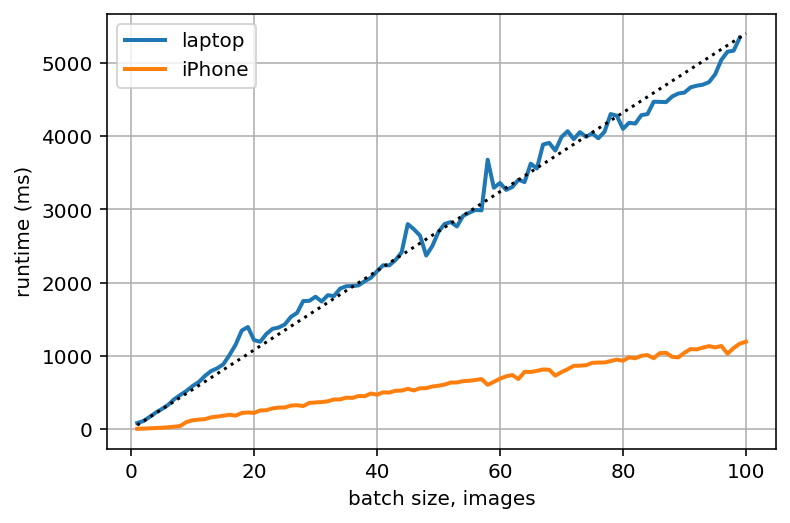

In [160]:
matplotlib.rcParams['figure.figsize'] = [6, 4]

plt.plot(range(1, 100), times_local_batch, lw=2, label="laptop")
plt.plot(range(1, 101), times_iphone, lw=2, label="iPhone")
plt.xlabel("batch size, images")
plt.ylabel("runtime (ms)")
plt.grid(which="major")
plt.legend()

p = 12*4.5
plt.plot([1, 100], [1*p, 100*p], ":k")
p

#plt.savefig("/Users/akusok/Documents/research-elm-twosystems/runtime.pdf", bbox_inches="tight")

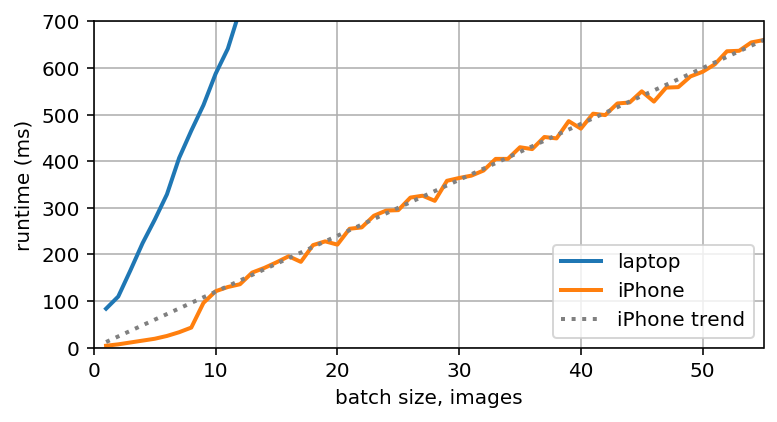

In [134]:
matplotlib.rcParams['figure.figsize'] = [6, 3]


plt.plot(range(1, 100), times_local_batch, lw=2, label="laptop")
plt.plot(range(1, 101), times_iphone, lw=2, label="iPhone")

p=12
plt.plot([1, 101], [p, 101*p], ':', c="gray", lw=2, label="iPhone trend")

plt.xlabel("batch size, images")
plt.ylabel("runtime (ms)")
plt.grid(which="major")
plt.legend()

plt.xlim([0, 55])
plt.ylim([0, 700])


plt.savefig("/Users/akusok/Documents/research-elm-twosystems/runtime_zoom.pdf", bbox_inches="tight")

#plt.plot(range(10, 31), ti2, lw=2)
#plt.plot(range(15, len(ti3)+15), ti3)

#plt.plot(range(1, len(toc2)+1), toc2, "-r", lw=3)

#plt.xlim([0, 25])
#plt.ylim([0, 300])

In [76]:
x = np.array(toc2[20:])
y = np.arange(21, 126)


In [79]:
from sklearn.linear_model import Ridge

In [86]:
Ridge().fit(y[:,None], x).coef_

array([11.60664932])

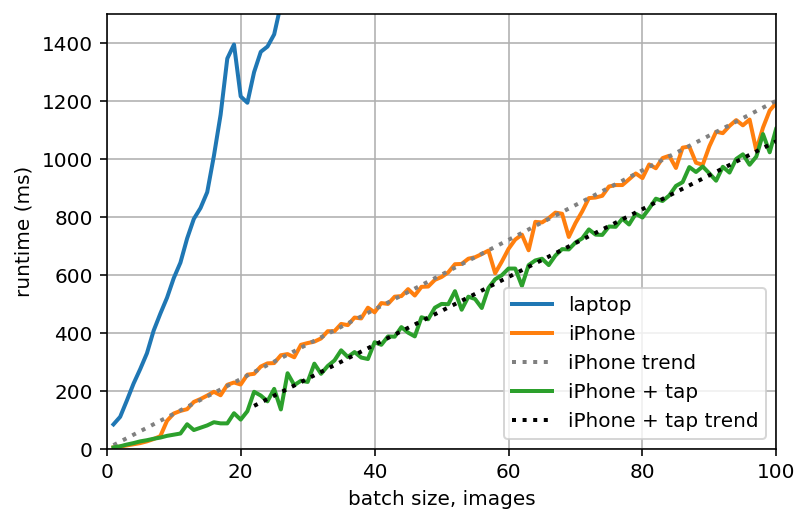

In [135]:
matplotlib.rcParams['figure.figsize'] = [6, 4]


plt.plot(range(1, 100), times_local_batch, lw=2, label="laptop")
plt.plot(range(1, 101), times_iphone, lw=2, label="iPhone")


p=12
plt.plot([1, 101], [p, 101*p], ':', c="gray", lw=2, label="iPhone trend")

p=11.7
plt.plot(range(1, 126), toc2, lw=2, label="iPhone + tap")
plt.plot([22, 126], [22*p-110, 126*p-110], ':', c="black", lw=2, label="iPhone + tap trend")

#q = 5
#plt.plot([1, 20], [4, 20*q], "--k", lw=1, label="iPhone boost")


plt.xlabel("batch size, images")
plt.ylabel("runtime (ms)")
plt.grid(which="major")
plt.legend()

plt.xlim([0, 100])
plt.ylim([0, 1500])


plt.savefig("/Users/akusok/Documents/research-elm-twosystems/runtime_trend.pdf", bbox_inches="tight")

#plt.plot(range(10, 31), ti2, lw=2)
#plt.plot(range(15, len(ti3)+15), ti3)

#plt.plot(range(1, len(toc2)+1), toc2, "-r", lw=3)

#plt.xlim([0, 25])
#plt.ylim([0, 300])

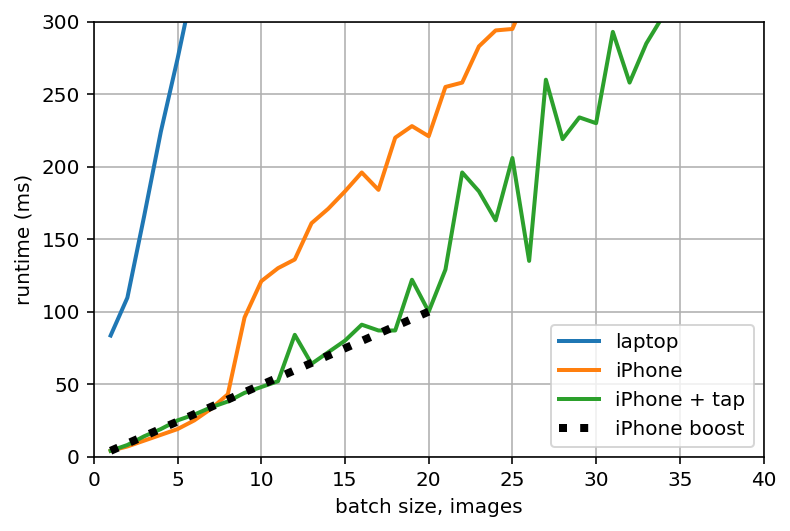

In [150]:
matplotlib.rcParams['figure.figsize'] = [6, 4]


plt.plot(range(1, 100), times_local_batch, lw=2, label="laptop")
plt.plot(range(1, 101), times_iphone, lw=2, label="iPhone")
plt.plot(range(1, 126), toc2, lw=2, label="iPhone + tap")

q = 5
plt.plot([1, 20], [4, 20*q], ":", c='k', lw=4, label="iPhone boost")


plt.xlabel("batch size, images")
plt.ylabel("runtime (ms)")
plt.grid(which="major")
plt.legend()

plt.xlim([0, 40])
plt.ylim([0, 300])


plt.savefig("/Users/akusok/Documents/research-elm-twosystems/runtime_boost.pdf", bbox_inches="tight")

#plt.plot(range(10, 31), ti2, lw=2)
#plt.plot(range(15, len(ti3)+15), ti3)

#plt.plot(range(1, len(toc2)+1), toc2, "-r", lw=3)

#plt.xlim([0, 25])
#plt.ylim([0, 300])

In [ ]:
times_iphone = [
4,
7,
11,
15,
24,
29,
39,
84,
107,
112,
136,
151,
158,
171,
180,
148,
97,
116,
134,
148,
157,
164,
163,
183,
305,
311,
311,
337,
344,
353,
375,
388,
386,
410,
407,
416,
420,
452,
468,
472,
493,
496,
511,
517,
529,
538,
576,
544,
581,
607,
600,
630,
628,
636,
664,
662,
682,
660,
691,
709,
673,
737,
751,
772,
796,
776,
789,
807,
823,
836,
861,
820,
865,
875,
892,
897,
913,
948,
941,
932,
963,
972,
972,
995,
1007,
1020,
1001,
1050,
1055,
1061,
1065,
1101,
1088,
1070,
1145,
1145,
1150,
1161,
1182,
1183]

Drop in time is unaffected by sleep delays, suggests some memory management

Keras: about 50ms/sample, starting at 80

iOS: about 10ms/sample, boosted to 5ms/sample at click, starting at 4

- 5x speed
- 10x boost speed
- 20x first sample speed

## Convert full model to iOS format

In [ ]:
model = kelm_mnet

In [ ]:
model.autho = "Anton Akusok"

In [ ]:
model.short_description = "MobileNet + ELM for classification"

In [ ]:
ielm = coremltools.converters.keras.convert(
    kelm_mnet,
    input_names="image",
    image_input_names="image",
    image_scale = 1/127.5,
    red_bias=-1,
    green_bias=-1,
    blue_bias=-1,
    class_labels=class_names
)

In [ ]:
ielm

In [ ]:
ielm.save("/Users/akusok/Documents/research-elm-twosystems/ielm.mlmodel")